This notebook reproduces the tables and figures from the paper that describe our results in hallucination mitigation. 

# Dependencies

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sacrebleu import CHRF, BLEU

In [3]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
from scipy.stats import ttest_rel

# Analysing reranking

### Loading data

In [5]:
with open('../computed_data/diverse-decoding-results.json', 'r') as f:
    unpacked = json.load(f)

In [6]:
smpl = pd.DataFrame(unpacked['data'])
smpl_diverse = unpacked['candidates']
hypotheses_scores = unpacked['candidate_scores']
selections = unpacked['selections']
sel_src_nli_raw = unpacked['nli_scores'] 
sel_comet_raw = unpacked['comet_scores'] 

### Figure 5: Heatmap of hallucination and rescoring methods quality

In [7]:
column_renames = {'ALTI_avg_sc': 'ALTI', 'ref_chrf': 'ChrF++'}

final_rankers = ['COMET-QE', 'ALTI_avg_sc', 'LASER2', 'LABSE', 'XNLI']
final_rankers_names = ['COMET-QE', 'ALTI', 'LASER2', 'LaBSE', 'XNLI']

In [8]:
sel_src_nli = {k1: {k2: np.mean(v2) for k2, v2 in v1.items()} for k1, v1 in sel_src_nli_raw.items()}
map_xnli = pd.DataFrame(sel_src_nli)
map_xnli.style.background_gradient(axis=None).format(precision=2)

,LABSE,COMET-QE,LASER2,ALTI_avg_sc,XNLI,ref_chrf,ref,first
default,0.51,0.51,0.51,0.51,0.51,0.51,0.81,0.51
sampling,0.57,0.47,0.47,0.36,0.64,0.44,0.81,0.31
sampling_p08,0.66,0.58,0.63,0.58,0.71,0.61,0.81,0.47
beam_search,0.65,0.61,0.63,0.61,0.68,0.62,0.81,0.57
beam_diversity_1,0.70,0.63,0.67,0.64,0.74,0.66,0.81,0.64
beam_diversity_3,0.72,0.65,0.68,0.63,0.75,0.66,0.81,0.63
beam_diversity_10,0.70,0.63,0.67,0.64,0.74,0.65,0.81,0.58
beam_dbs_1,0.70,0.63,0.66,0.63,0.74,0.64,0.81,0.60
beam_dbs_3,0.69,0.57,0.65,0.62,0.74,0.62,0.81,0.60
beam_dbs_10,0.69,0.55,0.64,0.54,0.75,0.62,0.81,0.59


In [9]:
pair2labse = {
    (smpl.src[i], hyp): hypotheses_scores['LABSE'][gen][i][j]
    for gen, by_gen in smpl_diverse.items()
    for i, hyps in enumerate(by_gen)
    for j, hyp in enumerate(hyps)
}

sel_labse = {
    scorer: {
        generator: np.mean([pair2labse[(smpl.src[i], mt)] for i, mt in enumerate(translations)])
        for generator, translations in by_scorer.items()
    } 
    for scorer, by_scorer in selections.items() if scorer != 'ref'
}

map_labse = pd.DataFrame(sel_labse)
map_labse.style.background_gradient(axis=None).format(precision=2)

,LABSE,COMET-QE,LASER2,ALTI_avg_sc,XNLI,ref_chrf,first
default,0.65,0.65,0.65,0.65,0.65,0.65,0.65
sampling,0.70,0.61,0.62,0.54,0.62,0.61,0.48
sampling_p08,0.76,0.68,0.72,0.67,0.71,0.70,0.61
beam_search,0.75,0.71,0.72,0.70,0.71,0.71,0.68
beam_diversity_1,0.78,0.74,0.75,0.72,0.74,0.74,0.71
beam_diversity_3,0.79,0.73,0.74,0.72,0.74,0.74,0.71
beam_diversity_10,0.78,0.72,0.73,0.72,0.73,0.74,0.69
beam_dbs_1,0.78,0.71,0.73,0.70,0.72,0.73,0.69
beam_dbs_3,0.78,0.69,0.72,0.69,0.72,0.71,0.69
beam_dbs_10,0.78,0.67,0.73,0.66,0.71,0.70,0.69


In [10]:
sel_comet = {k1: {k2: np.mean(v2) for k2, v2 in v1.items()} for k1, v1 in sel_comet_raw.items()}
map_comet = pd.DataFrame(sel_comet)
map_comet.style.background_gradient(axis=None).format(precision=2)

,LABSE,COMET-QE,LASER2,ALTI_avg_sc,XNLI,ref_chrf,ref,first
default,-0.63,-0.63,-0.63,-0.63,-0.63,-0.63,1.04,-0.63
sampling,-0.63,-0.57,-0.83,-1.07,-0.77,-0.66,1.04,-1.07
sampling_p08,-0.30,-0.29,-0.39,-0.48,-0.39,-0.30,1.04,-0.61
beam_search,-0.35,-0.35,-0.42,-0.46,-0.43,-0.29,1.04,-0.47
beam_diversity_1,-0.27,-0.28,-0.34,-0.40,-0.35,-0.19,1.04,-0.38
beam_diversity_3,-0.26,-0.28,-0.37,-0.41,-0.36,-0.22,1.04,-0.42
beam_diversity_10,-0.28,-0.28,-0.40,-0.42,-0.40,-0.22,1.04,-0.48
beam_dbs_1,-0.25,-0.25,-0.36,-0.42,-0.36,-0.22,1.04,-0.44
beam_dbs_3,-0.27,-0.29,-0.37,-0.44,-0.38,-0.24,1.04,-0.43
beam_dbs_10,-0.28,-0.33,-0.37,-0.57,-0.43,-0.28,1.04,-0.43


In [11]:
bleu_scorer = BLEU()

sel_ref_bleu = {
    selector: {
        sampler: bleu_scorer.corpus_score(sampled, [[t for t in smpl.ref]]).score
        for sampler, sampled in by_sampler.items()
    }
    for selector, by_sampler in selections.items()
}
map_bleu = pd.DataFrame(sel_ref_bleu)
map_bleu.style.background_gradient(axis=None).format(precision=2)

,LABSE,COMET-QE,LASER2,ALTI_avg_sc,XNLI,ref_chrf,ref,first
default,12.67,12.67,12.67,12.67,12.67,12.67,100.00,12.67
sampling,11.05,10.36,9.22,6.92,9.44,11.79,100.00,6.46
sampling_p08,15.27,13.97,13.55,12.05,13.55,17.57,100.00,11.02
beam_search,16.30,15.44,15.15,13.94,15.31,20.00,100.00,15.02
beam_diversity_1,17.92,17.21,16.80,15.52,16.28,22.56,100.00,17.65
beam_diversity_3,18.18,16.65,17.06,16.06,16.43,22.44,100.00,17.23
beam_diversity_10,18.25,17.57,17.33,16.95,17.04,21.52,100.00,15.73
beam_dbs_1,17.53,15.99,16.93,16.21,15.55,21.91,100.00,16.76
beam_dbs_3,16.14,14.32,15.63,14.64,14.39,20.22,100.00,16.38
beam_dbs_10,16.52,12.76,15.34,13.69,13.04,19.53,100.00,15.91


In [12]:
final_gens = [
    'default', 'beam_search', 'sampling', 'sampling_p08',
    'beam_dbs_1', 'beam_dbs_3', 'beam_dbs_10', 
    'beam_diversity_1', 'beam_diversity_3', 'beam_diversity_10',
    'greedy_dropout', 'beam_dropout',
]
final_gens_names = [
    'Default', 'Beam search', 'Sampling', 'Sampling P=80', 
    'DBS_1', 'DBS_3', 'DBS_10',
    'D_Dec_1', 'D_Dec_3', 'D_Dec_10',
    'MC gready', 'MC beam',
]

titles = ['XNLI', 'LaBSE', 'COMET', 'BLEU']

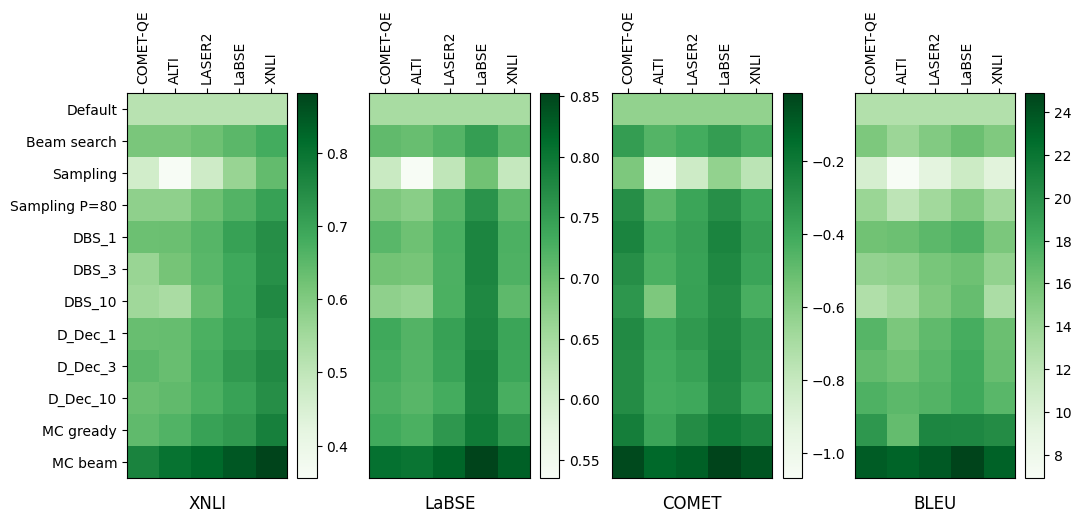

In [13]:
plt.figure(figsize=(12, 5))

for i, the_map in enumerate([map_xnli, map_labse, map_comet, map_bleu]):    
    ax = plt.subplot(1, 4, i+1)
    im = ax.imshow(the_map.loc[final_gens, final_rankers], cmap='Greens')
    cbar = ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks(np.arange(len(final_rankers_names)), labels=final_rankers_names)
    if i == 0:
        ax.set_yticks(np.arange(len(final_gens_names)), labels=final_gens_names)
    else:
        ax.set_yticks([])
        ax.tick_params(left=False)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    plt.title(titles[i], y=-0.1)

### Table 2: average COMET scores by initial pahology group

In [14]:
methods = ['COMET-QE', 'ALTI_avg_sc', 'LASER2', 'LABSE', 'XNLI']
method_names = ['No reranking', 'COMET-QE', 'ALTI', 'LASER', 'LaBSE', 'XNLI']

In [15]:
smpl2 = smpl.copy()
smpl2['baseline'] = pd.Series(sel_comet_raw['first']['default'], index=smpl.index)
for score_method in methods:
    smpl2[score_method] = sel_comet_raw[score_method]['beam_dropout']

table = smpl2.groupby('error_class').mean(numeric_only=True).iloc[:, 10:].T
table.index = method_names
table = table[[3, 2, 1, 0]]
table.columns = ['Fully detached', 'Strongly detached', 'Other errors', 'Correct']
table['Average'] = table.mean(axis=1)
table.style.background_gradient(axis=None).format(precision=2)

,Fully detached,Strongly detached,Other errors,Correct,Average
No reranking,-1.23,-0.97,-0.59,0.27,-0.63
COMET-QE,-0.21,-0.13,-0.14,0.35,-0.03
ALTI,-0.17,-0.24,-0.39,0.25,-0.14
LASER,-0.11,-0.23,-0.35,0.27,-0.11
LaBSE,-0.07,-0.12,-0.26,0.39,-0.01
XNLI,-0.12,-0.18,-0.28,0.30,-0.07


### Table 3:  average XNLI scores by initial pahology group

In [16]:
smpl2 = smpl.copy()
smpl2['baseline'] = pd.Series(sel_src_nli_raw['first']['default'], index=smpl.index)
for score_method in methods:
    smpl2[score_method] = sel_src_nli_raw[score_method]['beam_dropout']

table = smpl2.groupby('error_class').mean(numeric_only=True).iloc[:, 10:].T * 100
table.index = method_names
table = table[[3, 2, 1, 0]]
table.columns = ['Fully detached', 'Strongly detached', 'Other errors', 'Correct']
table['Average'] = table.mean(axis=1)
table.style.background_gradient(axis=None).format(precision=2)

,Fully detached,Strongly detached,Other errors,Correct,Average
No reranking,2.16,29.79,80.25,92.85,51.26
COMET-QE,59.49,69.33,84.78,92.76,76.59
ALTI,63.80,73.02,92.26,91.10,80.05
LASER,71.60,72.95,92.20,91.99,82.18
LaBSE,73.61,79.64,92.06,94.44,84.94
XNLI,75.26,82.58,98.01,96.87,88.18


# Effect of the number of hypotheses

In [17]:
with open('../computed_data/diverse-decoding-results-more-hypotheses.json', 'r') as f:
    unpacked_long = json.load(f)

### Figure 6: COMET scores for each generation method and number of hypotheses

In [18]:
selected_ids = {}

for k in range(1, 51):
    selected_ids[k] = {
        score_method: {
            gen_method: [
                np.argmax(unpacked_long['candidate_scores'][score_method][gen_method][i][:k])
                for i, hyps in enumerate(hyps_list)
            ]
            for gen_method, hyps_list in unpacked_long['candidates'].items()
        } 
        for score_method in unpacked_long['candidate_scores']
    }

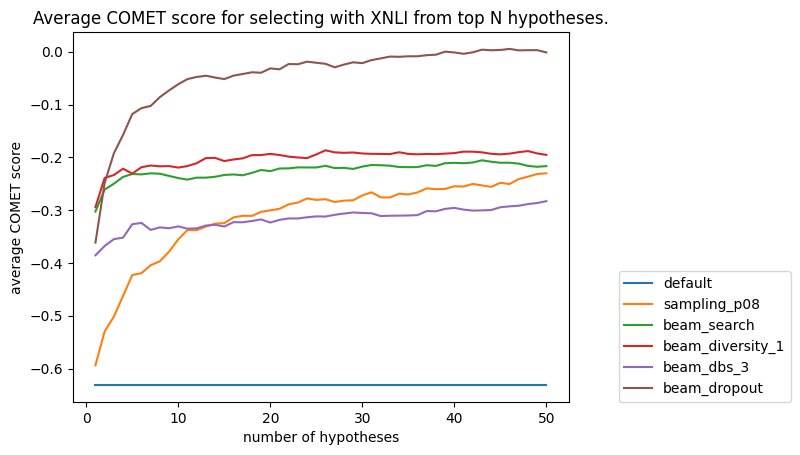

In [19]:
# select by XNLI, then score by Comet
scores = pd.DataFrame({
    k: {
        gen_method: np.mean([
            hyp_scores[hyp_id]
            for hyp_scores, hyp_id in zip(unpacked_long['candidate_scores']['COMET'][gen_method], chosen_ids) 
        ]) #np.mean(chosen_ids)
        for gen_method, chosen_ids in selected_for_size['XNLI'].items()
    }
    for k, selected_for_size in selected_ids.items()
}).T

scores.plot(
    xlabel='number of hypotheses', 
    ylabel='average COMET score',
    #title='mean best XNLI scores by generation method',
).legend(loc=(1.1, 0));
plt.title('Average COMET score for selecting with XNLI from top N hypotheses.');

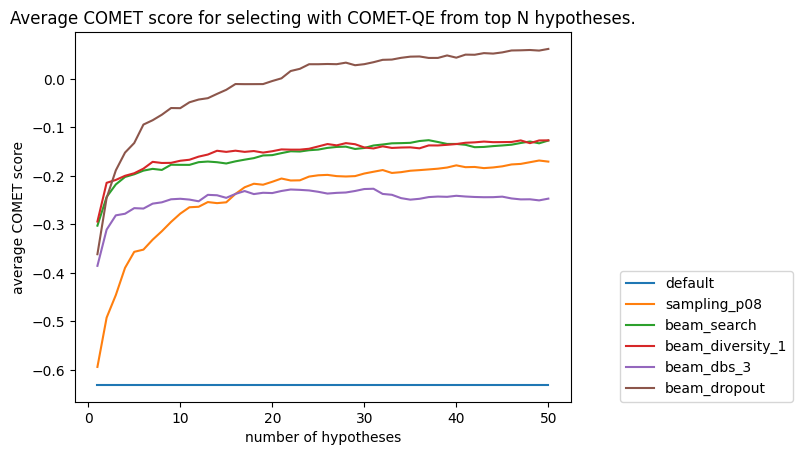

In [20]:
# select by XNLI, then score by Comet
scores = pd.DataFrame({
    k: {
        gen_method: np.mean([
            hyp_scores[hyp_id]
            for hyp_scores, hyp_id in zip(unpacked_long['candidate_scores']['COMET'][gen_method], chosen_ids) 
        ]) #np.mean(chosen_ids)
        for gen_method, chosen_ids in selected_for_size['COMET-QE'].items()
    }
    for k, selected_for_size in selected_ids.items()
}).T

scores.plot(
    xlabel='number of hypotheses', 
    ylabel='average COMET score',
    #title='mean best XNLI scores by generation method',
).legend(loc=(1.1, 0));
plt.title('Average COMET score for selecting with COMET-QE from top N hypotheses.');

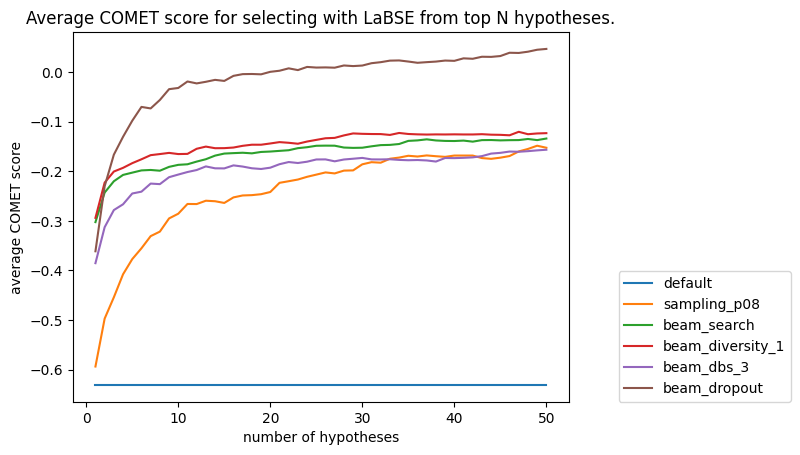

In [21]:
# select by XNLI, then score by Comet
scores = pd.DataFrame({
    k: {
        gen_method: np.mean([
            hyp_scores[hyp_id]
            for hyp_scores, hyp_id in zip(unpacked_long['candidate_scores']['COMET'][gen_method], chosen_ids) 
        ]) #np.mean(chosen_ids)
        for gen_method, chosen_ids in selected_for_size['LABSE'].items()
    }
    for k, selected_for_size in selected_ids.items()
}).T

scores.plot(
    xlabel='number of hypotheses', 
    ylabel='average COMET score',
    #title='mean best XNLI scores by generation method',
).legend(loc=(1.1, 0));
plt.title('Average COMET score for selecting with LaBSE from top N hypotheses.');

# Human annotations

In [22]:
stacked_annotations = pd.read_csv('../annotated_data/annotate_hallucination_mitigation_v7_stacked.tsv', sep='\t')

In [23]:
stacked_annotations.annotator.value_counts()

annotator_1    201
annotator_2    201
annotator_3    201
Name: annotator, dtype: int64

In [24]:
name_to_data = {name: data.reset_index(drop=True) for name, data in stacked_annotations.groupby('annotator')}

In [25]:
name_to_data.keys()

dict_keys(['annotator_1', 'annotator_2', 'annotator_3'])

### Compute agreement 

Extract lists of labels for each item from each annotator

In [26]:
label_colnames = [f'label{i}' for i in range(4)]
labelled_long = {k: v[label_colnames].unstack() for k, v in name_to_data.items()}

Compute label counts for each item and inter-annotator agreement

In [27]:
t2, labels = aggregate_raters(np.stack([v.dropna().values for v in labelled_long.values()], axis=1))

print(t2.shape)
print(fleiss_kappa(t2))

(602, 5)
0.5459463239444357


Compute ageement for coarse-grained labels

In [28]:
t3 = pd.DataFrame(t2, columns=labels)
t4 = pd.DataFrame({
    'Hallucination': t3['FULL_H'] + t3['PART_H'],
    'Error': t3['UNDER'] + t3['OTHER'],
    'OK': t3['OK'],
})

print(t4.shape)
print(fleiss_kappa(t4))

(602, 3)
0.566360827351435


Count ties

In [29]:
print(sum((t4.max(1)==1)))

20


### Figure 7: Percentages of translation pathologies before and after reranking

Undo deduplication of the translations

In [30]:
tran_names = [f'mt{i}' for i in range(4)]
all_systems = ['default', 'alti', 'labse', 'comet']

for k, v in name_to_data.items():
    for system in all_systems:
        eq = (v[f'mt_{system}'] == v[tran_names].T).T
        assert (eq.sum(1) == 1).all()
        v[f'label_{system}'] = v[label_colnames].values[eq.values]

Create a long table of labels on the text+system level

In [31]:
long_joint = []
for k, v in name_to_data.items():
    tmp = v[[f'label_{system}' for system in all_systems]].unstack().reset_index()
    tmp.columns = ['method', 'orig_id', 'label']
    tmp['who'] = k
    long_joint.append(tmp)

long_joint = pd.concat(long_joint)

Aggregate the labels

In [32]:
REMAP = {'FULL_H': 'Hallucination',  'PART_H': 'Hallucination', 'UNDER':'Error', 'OTHER':'Error', 'OK': 'Correct'}
PRIORITY2 = ['Hallucination',  'Error', 'Correct']


def choose_mode2(series):
    """ Return the most frequent value, and the most pessimistic value in case of ties."""
    vc = series.apply(lambda x: REMAP[x]).value_counts()
    if len(vc) == 1 or vc[0] > vc[1]:
        return vc.index[0]
    # tie resolution
    # print(dict(vc))
    top_labels = set(vc[vc==vc.max()].index)
    for label in PRIORITY2:
        if label in top_labels:
            return label

modes = long_joint.dropna().groupby(['method', 'orig_id']).label.apply(choose_mode2).reset_index()
modes

,method,orig_id,label
0,label_alti,0,Hallucination
1,label_alti,1,Hallucination
2,label_alti,2,Hallucination
3,label_alti,3,Correct
4,label_alti,4,Hallucination
...,...,...,...
799,label_labse,196,Error
800,label_labse,197,Hallucination
801,label_labse,198,Correct
802,label_labse,199,Error


In [33]:
ct = pd.crosstab(modes.method, modes.label).sort_values('Correct', ascending=False)
ct.index = [x[6:] for x in ct.index]
ct.rename(
    {'labse': 'LaBSE', 'comet': 'Comet-QE', 'alti': 'ALTI', 'default': 'Before reranking'}, 
    axis=0, inplace=True,
)
ct

label,Correct,Error,Hallucination
LaBSE,112,56,33
Comet-QE,109,47,45
ALTI,99,57,45
Before reranking,40,54,107


In [34]:
ct_norm = (ct.T / ct.sum(1)).T
ct_norm.style.format(precision=2)

label,Correct,Error,Hallucination
LaBSE,0.56,0.28,0.16
Comet-QE,0.54,0.23,0.22
ALTI,0.49,0.28,0.22
Before reranking,0.20,0.27,0.53


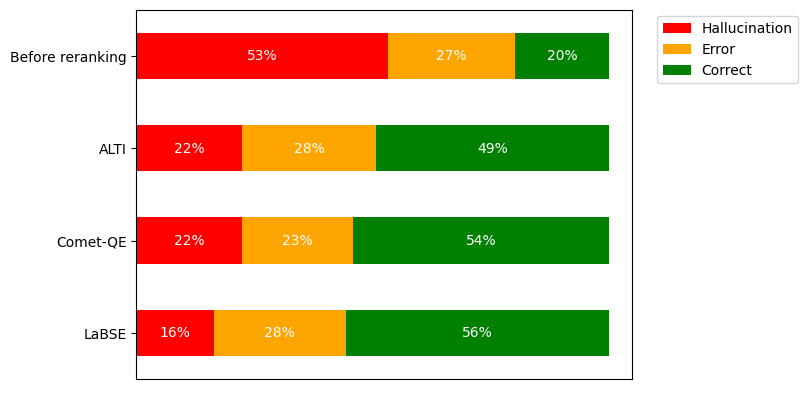

In [35]:
df = ct_norm.loc[
    ['Before reranking', 'ALTI', 'Comet-QE', 'LaBSE'][::-1],
    ['Correct', 'Error', 'Hallucination'][::-1],
]
ax = df.plot(kind='barh', stacked=True, legend=None, color=['red', 'orange', 'green'])
plt.legend(loc=(1.05, 0.8))

#for container in ax.containers:
#    ax.bar_label(container)

labels = [f'{i:.0%}' for i in df.to_numpy().flatten(order='F')]

for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() / 2
    ax.annotate(labels[i], (x, y), ha='center', va='center', c='white')

ax.set_xticks([]);

### Tables 5 and 6: Statistical significance of the differences

In [36]:
method_names = {'labse': 'LaBSE', 'comet': 'Comet-QE', 'alti': 'ALTI', 'default': 'No reranking'}

In [37]:
ct = pd.crosstab(modes.method, modes.label).sort_values('Correct', ascending=False)
diffs = []

for i, m1 in enumerate(ct.index):
    for m2 in ct.index[i+1:]:
        x1 = (modes[modes.method==m1].label == 'Correct').astype(int)
        x2 = (modes[modes.method==m2].label == 'Correct').astype(int)
        res = ttest_rel(x1, x2)
        diffs.append({
            'Method 1': method_names[m1[6:]], 'Method 2': method_names[m2[6:]], 
            'Rate 1': x1.mean(), 'Rate 2': x2.mean(), 
            'p-value': res.pvalue,
        })
diffs = pd.DataFrame(diffs)
diffs.style.format(precision=2)

,Method 1,Method 2,Rate 1,Rate 2,p-value
0,LaBSE,Comet-QE,0.56,0.54,0.53
1,LaBSE,ALTI,0.56,0.49,0.02
2,LaBSE,No reranking,0.56,0.20,0.00
3,Comet-QE,ALTI,0.54,0.49,0.12
4,Comet-QE,No reranking,0.54,0.20,0.00
5,ALTI,No reranking,0.49,0.20,0.00


The same is true for comparing hallucination rates

In [38]:
diffs = []

for i, m1 in enumerate(ct.index):
    for m2 in ct.index[i+1:]:
        x1 = (modes[modes.method==m1].label == 'Hallucination').astype(int)
        x2 = (modes[modes.method==m2].label == 'Hallucination').astype(int)
        res = ttest_rel(x1, x2)
        diffs.append({
            'Method 1': method_names[m1[6:]], 'Method 2': method_names[m2[6:]], 
            'Rate 1': x1.mean(), 'Rate 2': x2.mean(), 
            'p-value': res.pvalue,
        })

diffs = pd.DataFrame(diffs)
diffs.style.format(precision=2)

,Method 1,Method 2,Rate 1,Rate 2,p-value
0,LaBSE,Comet-QE,0.16,0.22,0.01
1,LaBSE,ALTI,0.16,0.22,0.01
2,LaBSE,No reranking,0.16,0.53,0.00
3,Comet-QE,ALTI,0.22,0.22,1.00
4,Comet-QE,No reranking,0.22,0.53,0.00
5,ALTI,No reranking,0.22,0.53,0.00
